In [24]:
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency,ttest_ind,mannwhitneyu,kstest
from sklearn.metrics import confusion_matrix
import pandas as pd
import json
from scipy.stats.mstats import kruskalwallis

In [2]:
import pandas as pd 
data = pd.read_excel('./data/0827/data_gt_60.xlsx')

In [3]:
single_df = data[data["LM_LAD_LCX_RCA"]=="单支"]
double_df = data[data["LM_LAD_LCX_RCA"]=="双支"]
multi_df = data[data["LM_LAD_LCX_RCA"]=="多支"]
quantitative_analysis = ["心率","舒张压","收缩压","年龄", "LDL-C检测值", "HDL-C检测值",
                         "TC检测值", "空腹血糖检测值","最高值肌酐检测值","首次血红蛋白检测值",
                        "CK-MB最高值检测值","TG检测值", "肌钙蛋白I最高值检测值","肌钙蛋白T最高值检测值",
                        "肌红蛋白最高值检测值","糖化血红蛋白检测值","BNP检测值","NT-proBNP检测值","LVEF","乳酸脱氢酶最高值检测值.2",
                        "TyG指数", "TG/HDL","年龄"]



# 定性分析的清单: 标签类型的数据 男女 是否
qualitative_analysis = ["性别","戒烟：无","吸烟史","饮酒史","既往心梗","脑血管病史",
                        '合并高血压','合并糖尿病',"既往心梗","心衰史","既往CABG","既往PCI",
                        "本次住院是否进行CABG治疗","室壁瘤.1","是否行PCI",
                        "乳头肌功能不全或断裂","室壁破裂","室间隔穿孔","附壁血栓","室壁瘤","并发症其他",
                        "冠状动脉支架植入术后再狭窄","冠状动脉支架内血栓形成","急性亚急性支架血栓形成","急性再发心肌梗死","再梗死","消化道出血.1","心脏瓣膜病",
                        "其他出血事件",
                        "入院诊断","首次心功能分级","出院主要诊断","mace" # 不是二值变量
                       ] 

In [4]:
save_list= []

def generate_array_lm(demo_df, col_name):
    group_stat = demo_df.value_counts([col_name,'LM_LAD_LCX_RCA']).reset_index().rename({0:"count"},axis=1)
    group_df = group_stat.pivot(index=col_name,columns='LM_LAD_LCX_RCA',values='count')
    # print(group_df)
    return np.array(group_df)

for col_name in qualitative_analysis: # 对定性分析的数据进行 卡方检验
    # 输出内容： mace 组的值 非mace组的各值
    # print(col_name)
    # if len(data[col_name].dropna()) < 1134:
    #     # print(f"{col_name}")
    #     print(data[col_name].value_counts())
    cur_single_info = single_df[col_name].value_counts().to_dict()
    cur_double_info = double_df[col_name].value_counts().to_dict()
    cur_multi_info = multi_df[col_name].value_counts().to_dict()
    
    
    # print(data[col_name].value_counts())
    
    cal_mat = generate_array_lm(data,col_name)
    chi2_res = chi2_contingency(cal_mat)
    # print()
    save_list.append([col_name,
                      json.dumps(cur_single_info,ensure_ascii=False), 
                     json.dumps(cur_double_info,ensure_ascii=False),
                     json.dumps(cur_multi_info,ensure_ascii=False),
                      
                      round(chi2_res.statistic,4),
                     round(chi2_res.pvalue,4)])
save_df = pd.DataFrame(save_list,columns=["指标","单支","双支","多支","统计值","p-value"])

single_total = len(single_df)
double_total = len(double_df)
multi_total = len(multi_df)
single_ratio, double_ratio,multi_ratio = [], [], []
for idx, col in save_df.iterrows():
    single_cont = json.loads(col['单支'])
    double_cont = json.loads(col['双支'])
    multi_cont = json.loads(col['多支'])
    if "是" in single_cont:
        single_cnt = single_cont['是']
        double_cnt = double_cont.get('是',0)
        multi_cnt = multi_cont.get('是',0)
    elif "true" in single_cont:
        single_cnt = single_cont['true']
        double_cnt = double_cont.get('true',0)
        multi_cnt = multi_cont.get('true',0)
    else:
        label = list(single_cont.keys())[0]
        single_cnt  = single_cont[label]
        double_cnt  = double_cont[label]
        multi_cnt = multi_cont[label]
        
    single_ratio.append(f"{round(single_cnt * 100 / single_total, 2)}%")
    double_ratio.append(f"{round(double_cnt * 100 / double_total, 2)}%")   
    multi_ratio.append(f"{round(multi_cnt * 100 / multi_total, 2)}%")   
    
save_df['单支比例'] = single_ratio
save_df['双支比例'] = double_ratio
save_df['多支比例'] = multi_ratio

dx_df = save_df # 定性分析结果
del save_df

In [6]:
dx_df.to_excel('./data/0830/多支病变定性分析.xlsx',index=None)

In [36]:
# single_df
# double_df
# multi_df


save_list = []
for col_name in quantitative_analysis: # 对多因素分析用kruskalwallis检验
    # 输出内容： mace 组的值 非mace组的各值
    data_mean,data_std = np.mean(data[col_name]), np.std(data[col_name]) 
    norm_res = stats.kstest(data[col_name], 'norm', (data_mean, data_std))
    if norm_res.pvalue > 0.05: # 大于0.05就是正态分布
        is_norm = True
    else:
        is_norm = False
    
    # print(col_name)
    # 填充空值
    single_df[col_name] = single_df[col_name].fillna(value=single_df[col_name].mean())
    double_df[col_name] = double_df[col_name].fillna(value=double_df[col_name].mean())
    
    multi_df[col_name] = multi_df[col_name].fillna(value=multi_df[col_name].mean())
   
    # --- >>> START stats <<< ---
    # Perform the Kruskal-Wallis test
    
    stat_kw, p_kw = kruskalwallis(single_df[col_name].to_numpy(),double_df[col_name].to_numpy(),multi_df[col_name].to_numpy())
    print(col_name)
    # print(is_norm, p,sep="\t")
    # 原有执行流程
    cur_single_arr = single_df[col_name].dropna()
    single_mean, single_std = np.mean(cur_single_arr), np.std(cur_single_arr)
    cur_double_arr = double_df[col_name].dropna()
    double_mean, double_std = np.mean(cur_double_arr), np.std(cur_double_arr)
    cur_multi_arr = multi_df[col_name].dropna()
    multi_mean, multi_std = np.mean(cur_multi_arr), np.std(cur_multi_arr)
    
    try:
        single_arr1, single_arr2, single_arr3 = np.percentile(cur_single_arr, [25, 50, 75]).tolist()
        double_arr1, double_arr2,double_arr3 = np.percentile(cur_double_arr, [25, 50, 75]).tolist()
        multi_arr1, multi_arr2, multi_arr3 = np.percentile(cur_multi_arr, [25, 50, 75]).tolist()
    except Exception:
        continue
    
    """
    
    statistic_t, p_value_t = ttest_ind(cur_single_arr, cur_double_arr)

    statistic_u, p_value_u = mannwhitneyu(cur_single_arr,cur_double_arr,alternative='two-sided')

    
    # print(data[col_name].value_counts())
    # cal_mat = generate_array(data,col_name)
    # chi2_res = chi2_contingency(cal_mat)
    # print()
    
    """
    save_list.append([col_name,
        f"{round(single_mean,2)}±{round(single_std,2)}",
        f"{round(double_mean,2)}±{round(double_std,2)}",
        f"{round(multi_mean,2)}±{round(multi_std,2)}",
        
          round(stat_kw,4),
        round(p_kw,4),
          f"{round(single_arr2,2)}({round(single_arr1,2)},{round(single_arr3,2)})",
          f"{round(double_arr2,2)}({round(double_arr1,2)},{round(double_arr3,2)})",
          f"{round(multi_arr2,2)}({round(multi_arr1,2)},{round(multi_arr3,2)})",

         is_norm ])
save_df = pd.DataFrame(save_list,columns=["指标","单支","双支","多支","kw检验值","p-value_kw", "单支-四分位", "双支-四分位", "多支-四分位", "是否正态分布"])

心率
舒张压
收缩压
年龄
LDL-C检测值
HDL-C检测值
TC检测值
空腹血糖检测值
最高值肌酐检测值
首次血红蛋白检测值
CK-MB最高值检测值
TG检测值
肌钙蛋白I最高值检测值
肌钙蛋白T最高值检测值
肌红蛋白最高值检测值
糖化血红蛋白检测值
BNP检测值
NT-proBNP检测值
LVEF
乳酸脱氢酶最高值检测值.2
TyG指数
TG/HDL
年龄


/tmp/ipykernel_3319/2210185927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_df[col_name] = single_df[col_name].fillna(value=single_df[col_name].mean())
/tmp/ipykernel_3319/2210185927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  double_df[col_name] = double_df[col_name].fillna(value=double_df[col_name].mean())
/tmp/ipykernel_3319/2210185927.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [37]:
save_df

,指标,单支,双支,多支,kw检验值,p-value_kw,单支-四分位,双支-四分位,多支-四分位,是否正态分布
0,心率,74.28±14.07,73.22±10.94,72.26±13.98,1.2282,0.5411,"72.0(65.0,80.75)","72.0(65.5,80.0)","69.0(64.5,76.5)",False
1,舒张压,72.7±10.72,72.13±10.09,68.45±12.19,4.2792,0.1177,"70.0(65.0,80.0)","70.0(67.0,80.0)","67.0(60.0,77.5)",False
2,收缩压,121.08±18.97,116.83±13.22,121.29±17.54,0.9405,0.6249,"120.0(109.25,130.75)","116.0(107.0,124.0)","118.0(110.0,133.5)",False
3,年龄,67.66±5.73,66.98±4.24,69.33±6.05,2.4350,0.2960,"66.42(63.0,71.21)","66.35(63.78,69.12)","68.67(64.03,73.87)",False
4,LDL-C检测值,2.63±0.92,2.72±0.72,2.96±1.19,2.2307,0.3278,"2.54(2.02,3.18)","2.59(2.22,3.36)","3.01(1.95,3.56)",True
5,HDL-C检测值,0.98±0.32,0.95±0.3,0.96±0.29,0.5055,0.7767,"0.94(0.76,1.2)","0.92(0.74,1.06)","0.92(0.75,1.11)",True
6,TC检测值,4.42±1.09,4.48±1.02,4.53±1.2,0.2038,0.9031,"4.36(3.7,5.05)","4.29(3.62,5.08)","4.42(3.71,5.46)",True
7,空腹血糖检测值,7.44±2.9,7.75±3.07,8.46±3.89,2.9898,0.2243,"6.64(5.43,8.73)","7.86(5.84,8.65)","7.09(6.15,9.59)",False
8,最高值肌酐检测值,92.78±50.45,93.1±38.52,101.32±63.39,0.2679,0.8746,"80.81(67.53,100.6)","75.6(68.75,106.4)","80.1(70.75,100.5)",False
9,首次血红蛋白检测值,140.73±16.9,140.84±14.15,142.66±13.44,0.4096,0.8148,"141.5(132.0,151.0)","144.0(138.0,148.0)","144.0(134.5,150.17)",True


In [38]:
dl_df = save_df
del save_df
dl_df.to_excel('./data/0830/多支病变定量分析.xlsx',index=None)

In [14]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
data= pd.read_excel('D:/shujufenxi/jpt.xlsx',index_col=0)
# 先来看下从城市因素开始分析，
df_city=data.melt(var_name='城市',value_name='月薪')#使用melt（）函数将读取数据进行结构转换，以满足ols（）函数对数据格式的要求，melt（）函数能将列标签转换为列数据

In [14]:
import matplotlib.pyplot  as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
import pandas as pd
import seaborn as sns
data= pd.read_excel('D:/shujufenxi/jpt.xlsx',index_col=0)
data_melt = data.melt()
data_melt.columns = ['城市', '月薪']
sns.boxplot(x = '城市', y = '月薪', data = data_melt)
plt.show()

In [14]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
data= pd.read_excel('D:/shujufenxi/jpt.xlsx',index_col=0)
# 先来看下从城市因素开始分析，
df_city=data.melt(var_name='城市',value_name='月薪')#使用melt（）函数将读取数据进行结构转换，以满足ols（）函数对数据格式的要求，melt（）函数能将列标签转换为列数据
model_city=ols('月薪~C(城市)',df_city).fit()# ols（）创建一线性回归分析模型
anova_table=anova_lm(model_city)# anova_lm（）函数创建模型生成方差分析表
print(anova_table)
# 进行事后比较分析
print(pairwise_tukeyhsd(df_city['月薪'], df_city['城市']))

In [14]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
data= pd.read_excel('D:/shujufenxi/jpt.xlsx',index_col=0)
df_twoway=data.stack().reset_index()
df_twoway.columns=['月份','城市','月薪']
model_twoway=ols('月薪~C(月份)+C(城市)',df_twoway).fit()
anova_table=anova_lm(model_twoway)
print(anova_table)

,ctl,treat1,treat2,treat3,treat4
0,11.688814,9.293261,24.891485,29.843914,32.912495
1,11.845016,11.452671,16.550755,30.115604,34.391529
2,2.951276,7.421364,22.171469,27.667488,31.061055
3,10.426292,9.579120,21.433345,37.287992,32.085165
4,14.497717,19.997673,27.263332,30.676373,32.331831


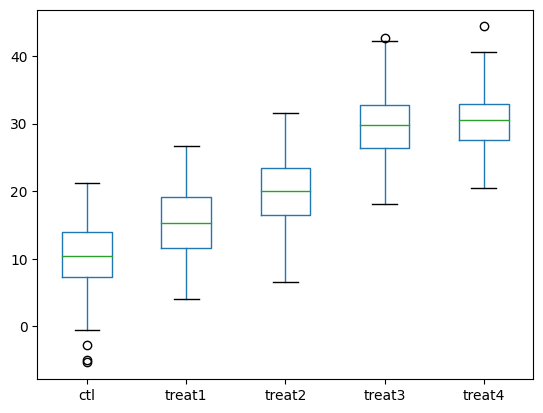

In [15]:
df.boxplot(grid = False)
import matplotlib.pyplot as plt
plt.show()

In [17]:
df_melt = df.melt()
df_melt.head()


df_melt.columns = ['Treat','Value']
df_melt.head()

,Treat,Value
0,ctl,11.688814
1,ctl,11.845016
2,ctl,2.951276
3,ctl,10.426292
4,ctl,14.497717


In [19]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
model = ols('Value~C(Treat)',data=df_melt).fit()
anova_table = anova_lm(model, typ = 2)
print(anova_table)

                sum_sq     df           F         PR(>F)
C(Treat)  31818.238173    4.0  306.853207  1.658445e-132
Residual  12831.891227  495.0         NaN            NaN


In [20]:
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df_melt['Value'],df_melt['Treat'])
tukey_result = mc.tukeyhsd(alpha = 0.5)
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.50 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ctl treat1   5.3055    0.0  4.1556  6.4554   True
   ctl treat2   9.8402    0.0  8.6903 10.9901   True
   ctl treat3  19.5143    0.0 18.3644 20.6642   True
   ctl treat4  20.5354    0.0 19.3855 21.6853   True
treat1 treat2   4.5347    0.0  3.3848  5.6846   True
treat1 treat3  14.2088    0.0 13.0589 15.3587   True
treat1 treat4  15.2299    0.0   14.08 16.3798   True
treat2 treat3   9.6741    0.0  8.5242  10.824   True
treat2 treat4  10.6952    0.0  9.5453 11.8451   True
treat3 treat4    1.021 0.6163 -0.1289  2.1709  False
----------------------------------------------------
